In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

!pip3 install tensorflow_hub
import tensorflow_hub as hub


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_file = "../../data/data_stat.txt"
dtf = pd.read_csv(data_file, sep = "\|\|", engine = "python")

In [117]:
dtf.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'Text_x', 'Text_y', 'Score'], dtype='object')

In [3]:
text_x = dtf["Text_x"]
text_y = dtf["Text_y"]
score = dtf["Score"]

In [5]:
score

0       2
1       1
2       1
3       1
4       1
       ..
3311    1
3312    2
3313    1
3314    1
3315    1
Name: Score, Length: 3316, dtype: int64

In [4]:
count_score = score.astype("str").astype("category").value_counts().tolist()

In [5]:
count_score

[2398, 380, 279, 158, 53, 46, 2]

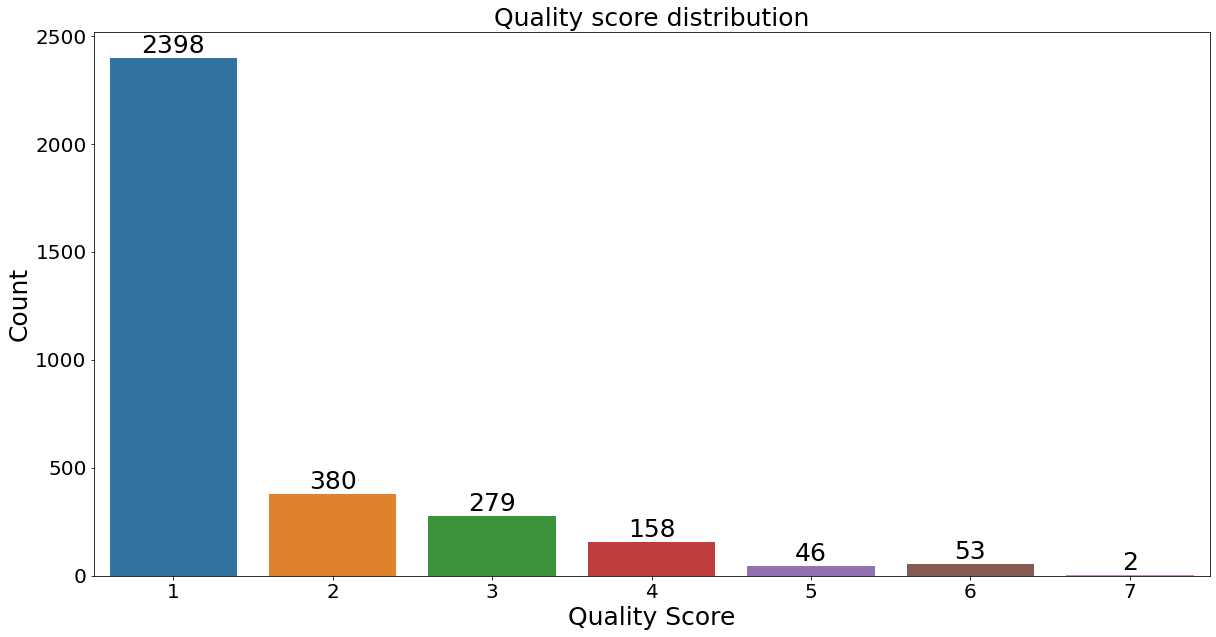

In [11]:
plt.figure(figsize=(20,10))
g = sns.countplot(x = score)
plt.title("Quality score distribution", fontsize = 25)
g.bar_label(g.containers[0], fontsize = 25)

plt.xlabel("Quality Score",fontsize = 25)
plt.ylabel("Count",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [7]:
length_x = text_x.apply(lambda line: len(line)).mean()

In [8]:
length_y = text_y.apply(lambda line: len(line)).mean()

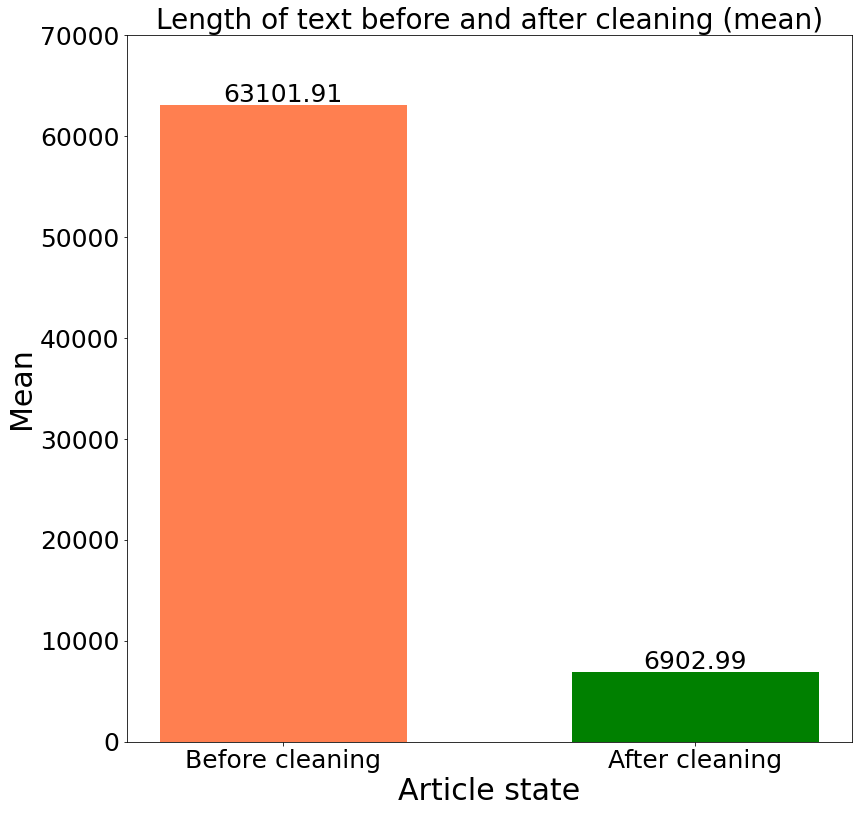

In [10]:

figure, axes = plt.subplots()
figure.set_figheight(13)
figure.set_figwidth(13)
plt.bar(["Before cleaning","After cleaning"], [length_x, length_y] , width = 0.6, color = ["coral", "green"])
plt.ylim(0,70000)

for p in axes.patches:
    axes.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points', fontsize = 25)

plt.xlabel("Article state",fontsize = 30)
plt.ylabel("Mean",fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.title("Length of text before and after cleaning (mean)", fontsize = 28)
plt.show()

In [12]:
len_x = text_x.apply(lambda line: len(line))
len_y = text_y.apply(lambda line: len(line))

In [13]:
data_len = pd.DataFrame({"Before cleaning" : len_x, "After cleaning": len_y})

In [127]:
data_len["Before"][data_len["Before"] > 500000]

KeyError: 'Before'

In [130]:
text_x[1]

"  abstract background  non-small cell lung cancer (nsclc) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-cbl is an e3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. we determined the genetic variations of c-cbl, relationship to receptor tyrosine kinases (egfr and met), and functionality in nscl  methods and findings  using archival formalin-fixed paraffin embedded (ffpe) extracted genomic dna, we show that c-cbl mutations occur in somatic fashion for lung cancers. c-cbl mutations were not mutually exclusive of met or egfr mutations; however they were independent of p53 and kras mutations. in normal/tumor pairwise analysis, there was significant loss of heterozygosity (loh) for the c-cbl locus (22%, n\u200a=\u200a8/37) and none of these samples revealed any mutation in the remaining copy of c-cbl. the c-cbl loh also positively correlated with egfr and met mutations observed in the same samples. using select

# Modele

In [133]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
    # lowercase text
    data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    return data

[nltk_data] Downloading package stopwords to /home/ragou/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [134]:
clean_text = pre_processing(text_y)

<ipython-input-133-2af2f6155045>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("\d","")
<ipython-input-133-2af2f6155045>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[^\w\s]","")


In [135]:

# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 2000 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(clean_text) # Updates internal vocabulary based on a list of texts.

In [136]:
tokenizer.word_index # get the index of each word

{'mutations': 1,
 'cells': 2,
 'mutation': 3,
 'figure': 4,
 'cell': 5,
 'mutant': 6,
 'exon': 7,
 'p': 8,
 'expression': 9,
 'patients': 10,
 'mutants': 11,
 'cancer': 12,
 'egfr': 13,
 'gene': 14,
 'activity': 15,
 'b': 16,
 'deletion': 17,
 'protein': 18,
 'c': 19,
 'domain': 20,
 'kinase': 21,
 'also': 22,
 'wildtype': 23,
 'table': 24,
 'analysis': 25,
 'tumors': 26,
 'two': 27,
 'tumor': 28,
 'data': 29,
 'results': 30,
 'wt': 31,
 'fusion': 32,
 'activation': 33,
 'found': 34,
 'identified': 35,
 'using': 36,
 'amplification': 37,
 'may': 38,
 'shown': 39,
 'variants': 40,
 'kit': 41,
 'binding': 42,
 'braf': 43,
 'lines': 44,
 'dna': 45,
 'one': 46,
 'genes': 47,
 'showed': 48,
 'observed': 49,
 'compared': 50,
 'growth': 51,
 'study': 52,
 'levels': 53,
 'phosphorylation': 54,
 'e': 55,
 'expressing': 56,
 'cases': 57,
 'deletions': 58,
 'supplementary': 59,
 'n': 60,
 'human': 61,
 'reported': 62,
 'amplif': 63,
 'mice': 64,
 'increased': 65,
 'however': 66,
 'insertion': 67,

In [137]:
# Pad the data 
X = tokenizer.texts_to_sequences(clean_text) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=2000) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)

In [138]:
X

array([[   0,    0,    0, ...,  455,  858,  244],
       [   0,    0,    0, ...,   12,    5,   44],
       [   0,    0,    0, ...,   12,    5,   44],
       ...,
       [   0,    0,    0, ...,  206,   25,  834],
       [   0,    0,    0, ...,  494, 1065,   11],
       [   0,    0,    0, ..., 1056, 1921,  141]], dtype=int32)

In [142]:
Y_D = pd.get_dummies(dtf['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(2652, 2000) (2652, 9)
(664, 2000) (664, 9)


In [162]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(5, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
#     model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [161]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [165]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = Tokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [171]:
train_input = bert_encode(XD_train, tokenizer)

AttributeError: 'Tokenizer' object has no attribute 'tokenize'

In [167]:
num_words = 2000
embed_dim = 128
lstm_out = 64

# model = Sequential(
#     [
#         Embedding(num_words, embed_dim, input_length = X.shape[1]),
#         LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2),
#         Dense(32, activation = "relu"),
#         Dense(9,activation='softmax')
#     ]
# )
model = build_model(bert_layer)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [169]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    XD_train, YD_train,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/5


ValueError: in user code:

    /home/ragou/.local/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/ragou/.local/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ragou/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ragou/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ragou/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ragou/.local/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/ragou/.local/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /home/ragou/.local/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ragou/.local/lib/python3.8/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2000) dtype=int32>]
